In [2]:
import pandas as pd
import umap

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler

In [8]:

## Read Data from CSV
path = '../data/full_raquets_dataset.csv'
df = pd.read_csv(path, index_col='Model')
df = df.rename(columns={'StringDensity':'StringOpenness'})
df.head()

,HeadSize,Length,StrungWeight,UnStrungWeight,SwingWeight,Balance,Stiffness,BeamWidth1,BeamWidth2,BeamWidth3,NumMains,NumCrosses,MinStringTension,MaxStringTension,StringOpenness,Brand
Model,,,,,,,,,,,,,,,,
WilsonRolandGarrosEquipeHP,100.0,68.5,301.0,286.0,300.0,34.0,68.0,23.0,26.0,24.0,16.0,19.0,22.0,27.0,0.328947,Wilson
WilsonBlade98Sv9,98.0,68.5,313.0,295.0,299.0,33.5,62.0,20.6,20.6,20.6,18.0,16.0,22.0,27.0,0.340278,Wilson
WilsonBlade9816x19v9,98.0,68.5,323.0,305.0,324.0,33.0,62.0,21.0,21.0,21.0,16.0,19.0,22.0,27.0,0.322368,Wilson
WilsonUltra100LV4.0,100.0,68.5,295.0,280.0,299.0,33.0,64.0,24.0,26.5,24.2,16.0,19.0,22.0,27.0,0.328947,Wilson
WilsonBladeFeel103,103.0,68.5,278.0,264.0,308.0,34.0,68.0,23.0,23.0,23.0,16.0,20.0,22.0,27.0,0.321875,Wilson


## Plan 

1. Initial Umap
2. EDA and understanding of the data
3. Scaling, removing outliers and tuning parameter before final plot

In [9]:
df.groupby('Brand').size()

Brand
Babolat        40
Dunlop         25
Head           39
Lacoste         3
Prince         33
ProKennex      25
Solinco         8
Technifibre    12
Volkl          24
Wilson         41
Yonex          28
dtype: int64

# Initial UMAP

/opt/anaconda3/envs/raquet/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


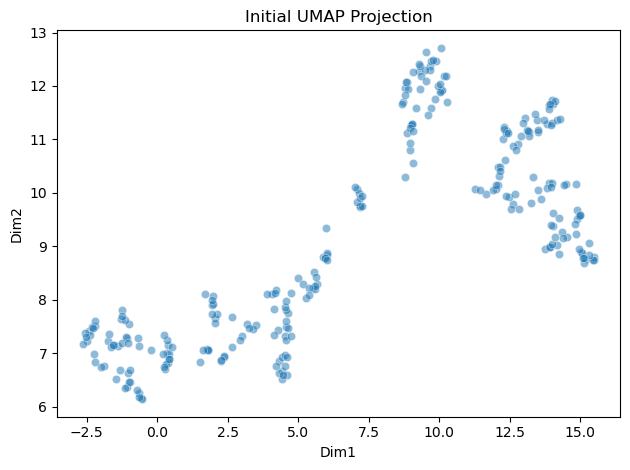

In [10]:



## Select Columns for initial UMAP
cols = ['HeadSize', 
        'Length',
        'UnStrungWeight',
        'StrungWeight',
        'SwingWeight',
        'Balance',	
        'Stiffness',	
        'BeamWidth1',	
        'BeamWidth2',	
        'BeamWidth3',	
    	'MinStringTension',
        'MaxStringTension',
        'StringOpenness']
data = df[cols]


## Fit UMAP to data 
umap_model = umap.UMAP(random_state=42)
umap_result = umap_model.fit_transform(data)
umap_df = pd.DataFrame(umap_result, columns=['Dim1', 'Dim2'])


## Plot UMAP Projections
fig, ax = plt.subplots()
sns.scatterplot(x='Dim1', y='Dim2',  data=umap_df, alpha=0.5)
plt.title('Initial UMAP Projection')
plt.tight_layout()
plt.show()
fig.savefig('../plots/intial_umap.png')




In [11]:
umap_model = umap.UMAP(random_state=42)
umap_result = umap_model.fit_transform(data)

/opt/anaconda3/envs/raquet/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


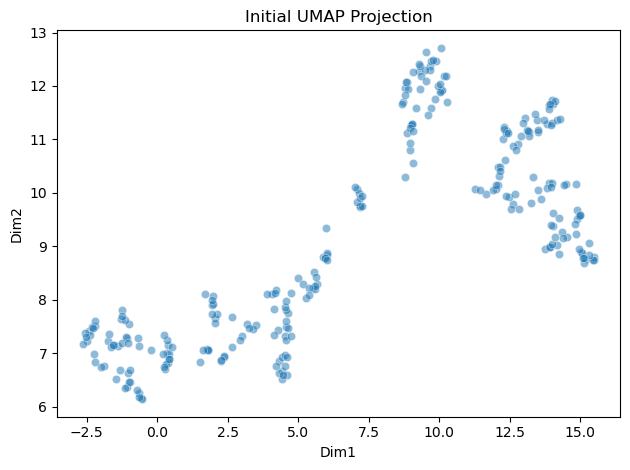

In [12]:
fig, ax = plt.subplots()
sns.scatterplot(x='Dim1', y='Dim2',  data=umap_df, alpha=0.5)
plt.title('Initial UMAP Projection')
plt.tight_layout()
plt.show()



We can see that straightforward approach in applying UMAP and expecting good results is not something we can expect. While we can obeserve some clusters, but the're quite big, so the won't be too helpful in searching for similar raquets.

What are the strategies to improve the UMAP projection:

1. Improving dataset by removing outliers
2. Having deeper look at the features themselves
3. Scaling data before inserting it into the UMAP
4. Tuning parameters to obtain the result

## Improving dataset by removing outliers

In [13]:
df.query('BeamWidth1 > 200')

,HeadSize,Length,StrungWeight,UnStrungWeight,SwingWeight,Balance,Stiffness,BeamWidth1,BeamWidth2,BeamWidth3,NumMains,NumCrosses,MinStringTension,MaxStringTension,StringOpenness,Brand
Model,,,,,,,,,,,,,,,,
TecnifibreTFightISO280,100.0,68.5,298.0,280.0,310.0,33.5,68.0,243.0,23.0,23.0,16.0,19.0,22.0,24.0,0.328947,Technifibre


This is clearly irregular data point, it's impossible for this single raquet to have one such wide Beam, while others are have normal values. I can remove it from the dataset, because I do not know actual specs.

In [14]:
df = df.query('BeamWidth1 < 200')

In [15]:
## EDA

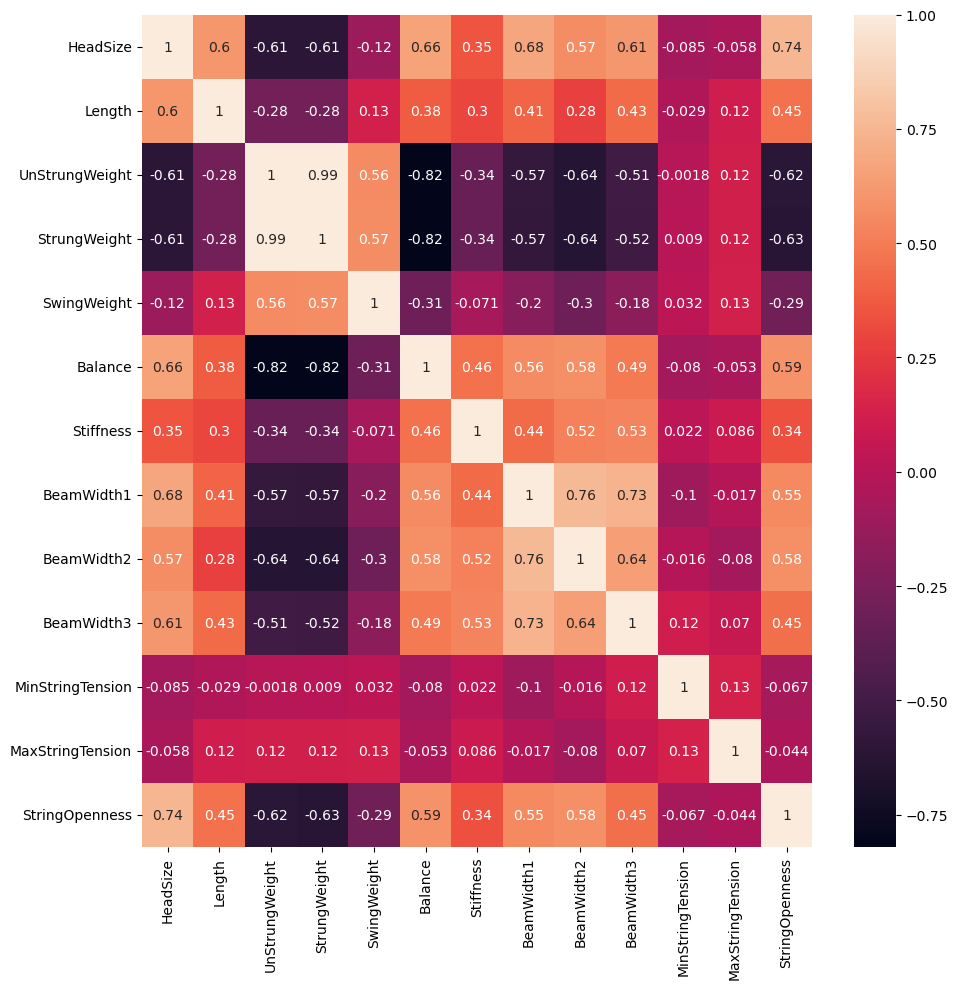

In [16]:
fig, axes = plt.subplots(1,1, figsize=(10, 10))

sns.heatmap(df[cols].corr(), annot= True)
plt.tight_layout()
plt.show()

fig.savefig('../plots/cor_plot.png')


What we can imediatly see, is that StrungWeight and UnStrungWeight are effectivelly equivalent. With correlation of 0.99 there's very little additional information from one of them, as long we have the other one in the dataset. I will remove StrungWeight, since unstrung weight is what is usually displayed on the raquet and will be easier to interpret. 

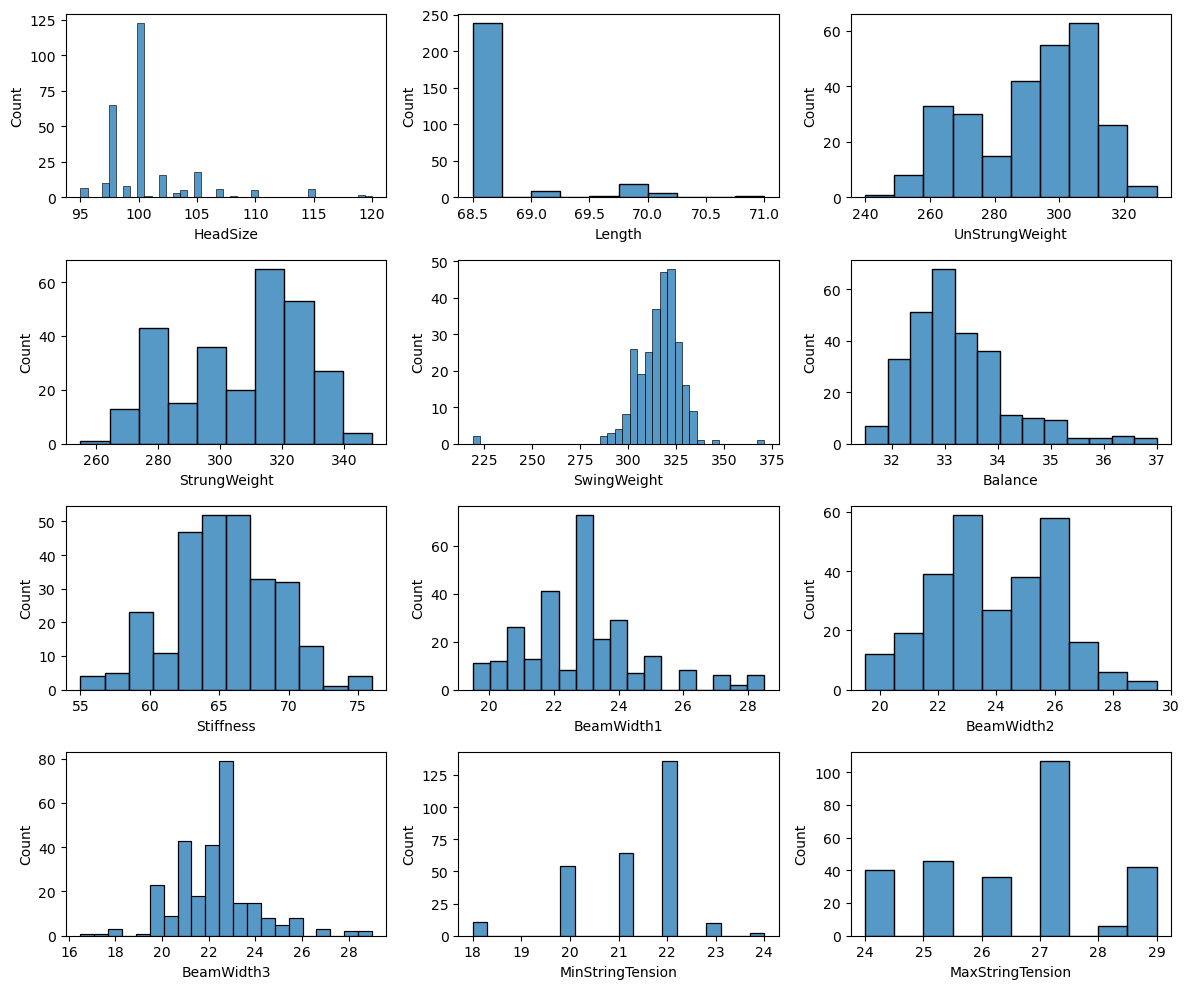

In [17]:
fig, axes = plt.subplots(4,3, figsize=(12, 10))
axes_flat = axes.flatten()

for ax, col in zip(axes_flat, cols):
    sns.histplot(x=col, data=df, ax=ax)

plt.tight_layout()
plt.show()

### Scaling Data

There are several ways to scale data avalilable in ScikitLearn, which  might be beneficial for dimensionality reduction and clustering: standard scaling, quantile scaling, min max scaling. But let's first talk about the issue of not scaling the data.
Because clustering algorithms and dimesionality algorithms tend to rely on distance between the points, so if feauteres are on different scale, the ones which are on bigger one will have outsized importance. Im my dataset there are no outragiously big diggerences in scale, but when we look at Stiffness with mean value of 65 and weight with value of 290, we can see that the same relative difference from the mean will have widely different impact on distance between points. So let's take a look on how to solve it:

1. StandardScaler
2. MinMax Scaler
3. QuantileScaler

In [29]:
cols = ['HeadSize', 
        #'Length',
        'UnStrungWeight',
        #'StrungWeight',
        'SwingWeight',
        'Balance',	
        'Stiffness',	
        'BeamWidth1',	
        'BeamWidth2',	
        'BeamWidth3',	
    	'MinStringTension',
        'MaxStringTension',
        'StringOpenness'
       ]

In [30]:
scl = QuantileTransformer(output_distribution='uniform', n_quantiles=100)
#scl =MinMaxScaler()
data = df[cols]
standardized_data = scl.fit_transform(data)


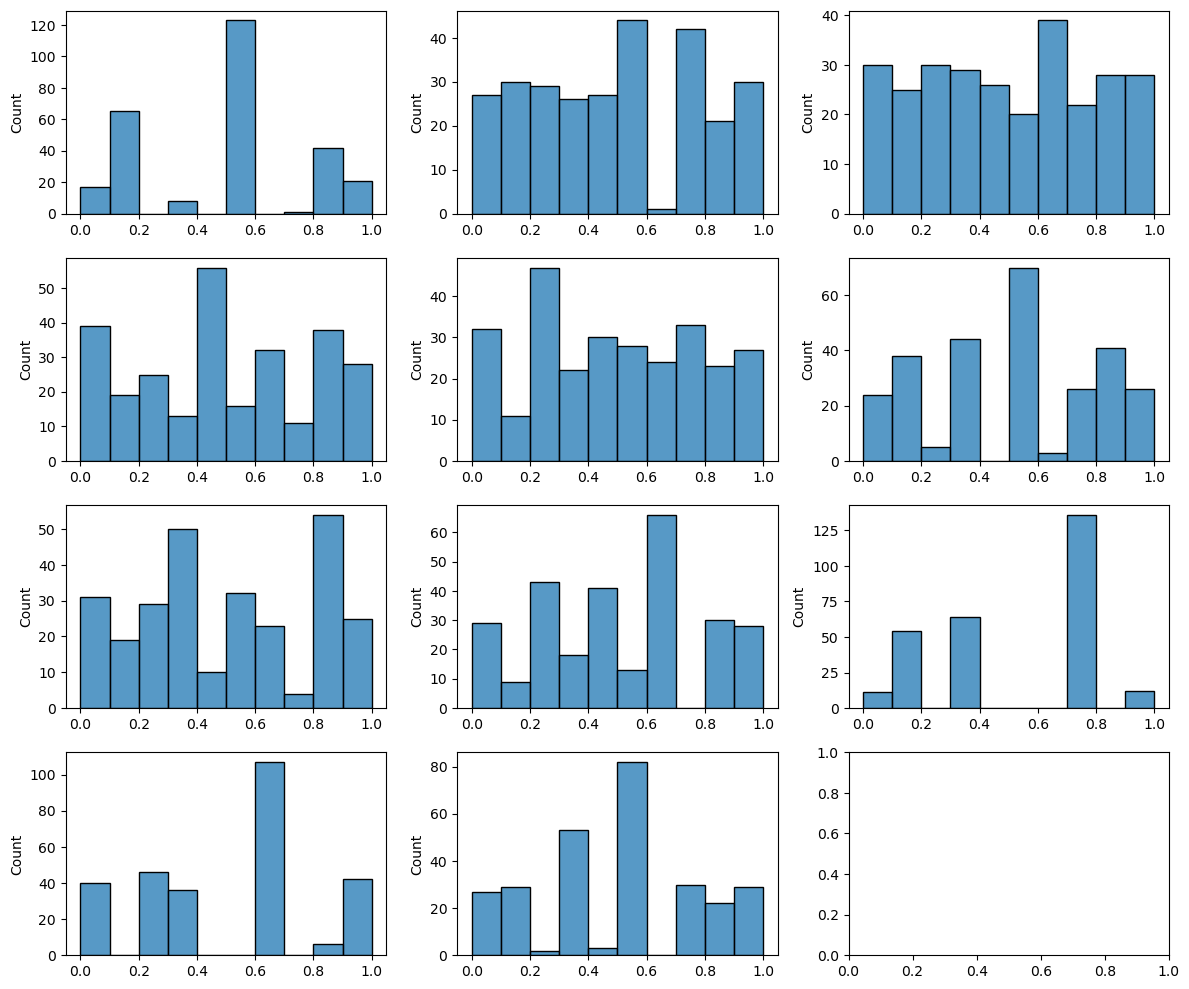

In [31]:
fig, axes = plt.subplots(4,3, figsize=(12, 10))
axes_flat = axes.flatten()
col_inds = range(len(cols))
for ax, col, cl in zip(axes_flat, cols, col_inds):
    sns.histplot(standardized_data[:, cl], ax=ax)

plt.tight_layout()
plt.show()

## Fit UMAP

In [32]:
umap_model = umap.UMAP(n_neighbors=3,min_dist=0.01, random_state=42)
umap_result = umap_model.fit_transform(standardized_data)

/opt/anaconda3/envs/raquet/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [42]:
umap_df = pd.DataFrame(umap_result, columns=['Dim1', 'Dim2'])
umap_df = umap_df.set_index(df.index)
umap_df.head()

,Dim1,Dim2
Model,,
WilsonRolandGarrosEquipeHP,8.818244,15.141145
WilsonBlade98Sv9,3.866118,4.169265
WilsonBlade9816x19v9,0.515422,0.371385
WilsonUltra100LV4.0,9.779032,16.331625
WilsonBladeFeel103,6.225134,7.917566


In [43]:
df2 = pd.concat([df,umap_df ], axis =1)

## Vizualize data

In [69]:
df2['MyRaquet'] = (df2.index=='YonexPercept97H').astype(int)



,HeadSize,Length,StrungWeight,UnStrungWeight,SwingWeight,Balance,Stiffness,BeamWidth1,BeamWidth2,BeamWidth3,NumMains,NumCrosses,MinStringTension,MaxStringTension,StringOpenness,Brand,Dim1,Dim2,MyRaquet,Condition
Model,,,,,,,,,,,,,,,,,,,,
YonexPercept97H,97.0,68.5,346.0,330.0,333.0,32.0,62.0,21.0,21.0,21.0,16.0,19.0,20.0,27.0,0.319079,Yonex,12.043288,-7.200553,1,1


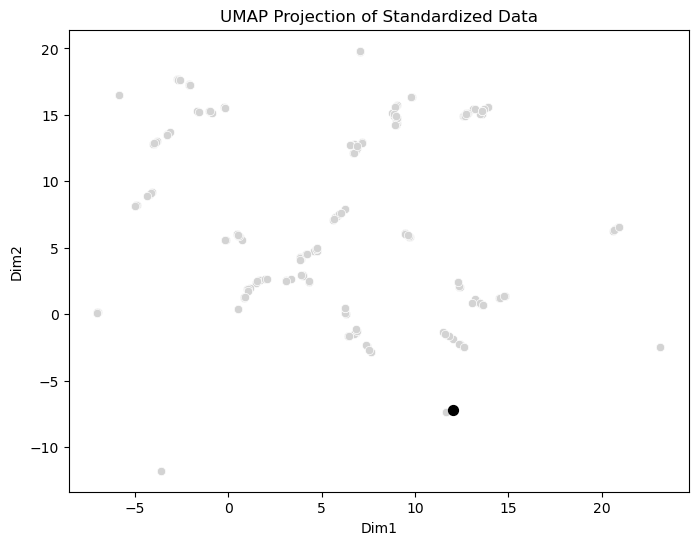

In [47]:
fig, ax = plt.subplots(1,1,figsize=(8, 6))
sns.scatterplot(x='Dim1', y='Dim2',  data=df2.loc[df2['MyRaquet'] != 1], ax=ax, color='lightgrey')
plt.scatter(df2.loc[df2['MyRaquet'] == 1,'Dim1'] , df2.loc[df2['MyRaquet'] == 1,'Dim2'], color='black', s=50, )

plt.title('UMAP Projection of Standardized Data')
plt.show()

In [70]:
df2['MyRaquet'] = (df2.index=='YonexPercept97H').astype(int)
condition = (df2.Dim2 < -5)  & (df2.Dim1> 5) 


In [71]:
df2['Condition'] = condition.astype(int)

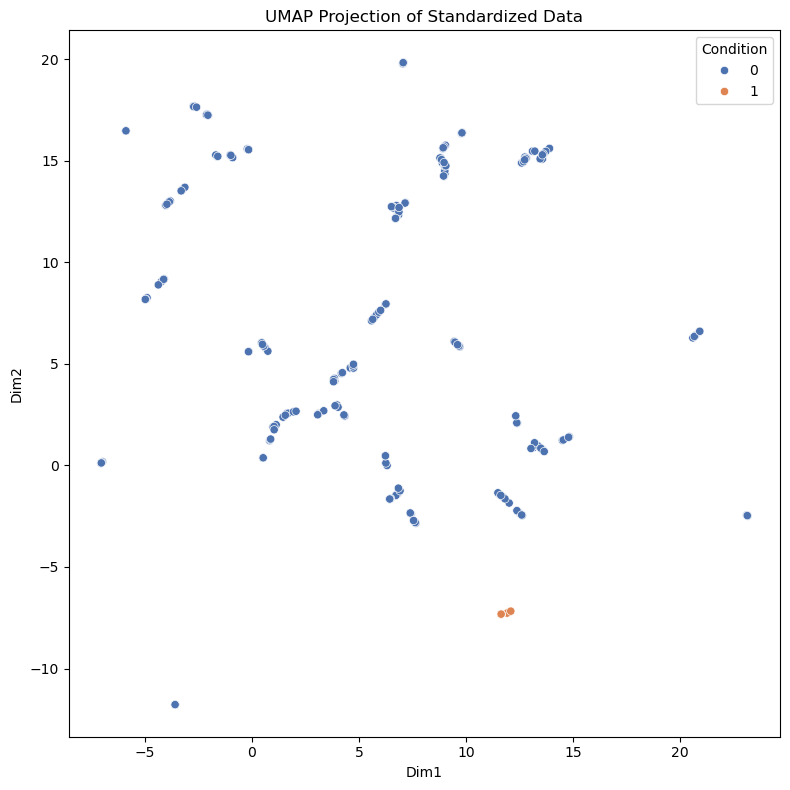

In [72]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
sns.scatterplot(x='Dim1', y='Dim2', hue='Condition', data=df2, palette="deep")
plt.title('UMAP Projection of Standardized Data')
plt.tight_layout()
plt.show()
fig.savefig('../plots/yonex_percept97H.png')



In [76]:
df2.loc[df2.Condition == 1]

,HeadSize,Length,StrungWeight,UnStrungWeight,SwingWeight,Balance,Stiffness,BeamWidth1,BeamWidth2,BeamWidth3,NumMains,NumCrosses,MinStringTension,MaxStringTension,StringOpenness,Brand,Dim1,Dim2,MyRaquet,Condition
Model,,,,,,,,,,,,,,,,,,,,
YonexPercept97H,97.0,68.5,346.0,330.0,333.0,32.0,62.0,21.0,21.0,21.0,16.0,19.0,20.0,27.0,0.319079,Yonex,12.043288,-7.200553,1,1
YonexVCORE95(310g)2023,95.0,68.5,326.0,310.0,321.0,32.0,61.0,22.0,22.0,21.0,16.0,19.0,20.0,27.0,0.312500,Yonex,12.007488,-7.217495,0,1
YonexPercept97,97.0,68.5,326.0,310.0,315.0,32.0,60.0,21.0,21.0,21.0,16.0,19.0,20.0,27.0,0.319079,Yonex,11.910560,-7.269501,0,1
YonexPercept97D,97.0,68.5,337.0,320.0,329.0,32.0,62.0,21.0,21.0,21.0,18.0,20.0,20.0,27.0,0.269444,Yonex,12.084275,-7.173600,0,1
DunlopCX200Tour18x20(315g),95.0,68.5,332.0,315.0,316.0,32.0,66.0,20.5,20.5,20.5,18.0,20.0,20.0,29.0,0.263889,Dunlop,11.632108,-7.320340,0,1
DunlopSrixonCX200Tour16x19(310g),95.0,68.5,326.0,310.0,318.0,32.0,63.0,20.5,20.5,20.5,16.0,19.0,20.0,29.0,0.312500,Dunlop,11.636470,-7.319656,0,1
DunlopCX200Tour16x19(310g),95.0,68.5,326.0,310.0,314.0,32.0,66.0,20.5,20.5,20.5,16.0,19.0,20.0,29.0,0.312500,Dunlop,11.633427,-7.320243,0,1
DunlopSrixonCX200Tour18x20(315g),95.0,68.5,332.0,315.0,319.0,32.0,62.0,20.5,20.5,20.5,18.0,20.0,20.0,29.0,0.263889,Dunlop,11.633592,-7.320121,0,1


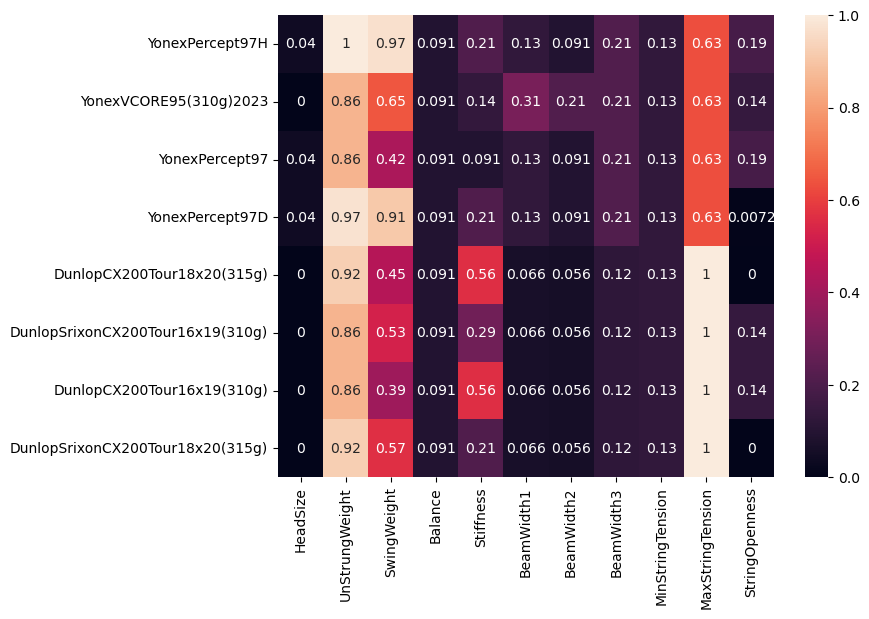

In [81]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.heatmap(standardized_data[df2.Condition == 1], 
            ax=ax,
            xticklabels=cols,
            yticklabels=df2.loc[df2.Condition == 1].index,
            annot=True)
plt.show()

In [87]:
def custom_format(val):
    if val % 1 == 0:  # If the value is an integer
        return f'{int(val)}'  # Display as integer
    else:
        return f'{val:.2f}'  # Display with one decimal place
formated_data = df2.loc[condition, cols].applymap(custom_format)

/var/folders/hj/l0ykck3j5b97jv8dbw8wkw0r0000gn/T/ipykernel_38306/2154268381.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formated_data = df2.loc[condition, cols].applymap(custom_format)


In [88]:
formated_data

,HeadSize,UnStrungWeight,SwingWeight,Balance,Stiffness,BeamWidth1,BeamWidth2,BeamWidth3,MinStringTension,MaxStringTension,StringOpenness
Model,,,,,,,,,,,
YonexPercept97H,97,330,333,32,62,21,21,21,20,27,0.32
YonexVCORE95(310g)2023,95,310,321,32,61,22,22,21,20,27,0.31
YonexPercept97,97,310,315,32,60,21,21,21,20,27,0.32
YonexPercept97D,97,320,329,32,62,21,21,21,20,27,0.27
DunlopCX200Tour18x20(315g),95,315,316,32,66,20.50,20.50,20.50,20,29,0.26
DunlopSrixonCX200Tour16x19(310g),95,310,318,32,63,20.50,20.50,20.50,20,29,0.31
DunlopCX200Tour16x19(310g),95,310,314,32,66,20.50,20.50,20.50,20,29,0.31
DunlopSrixonCX200Tour18x20(315g),95,315,319,32,62,20.50,20.50,20.50,20,29,0.26


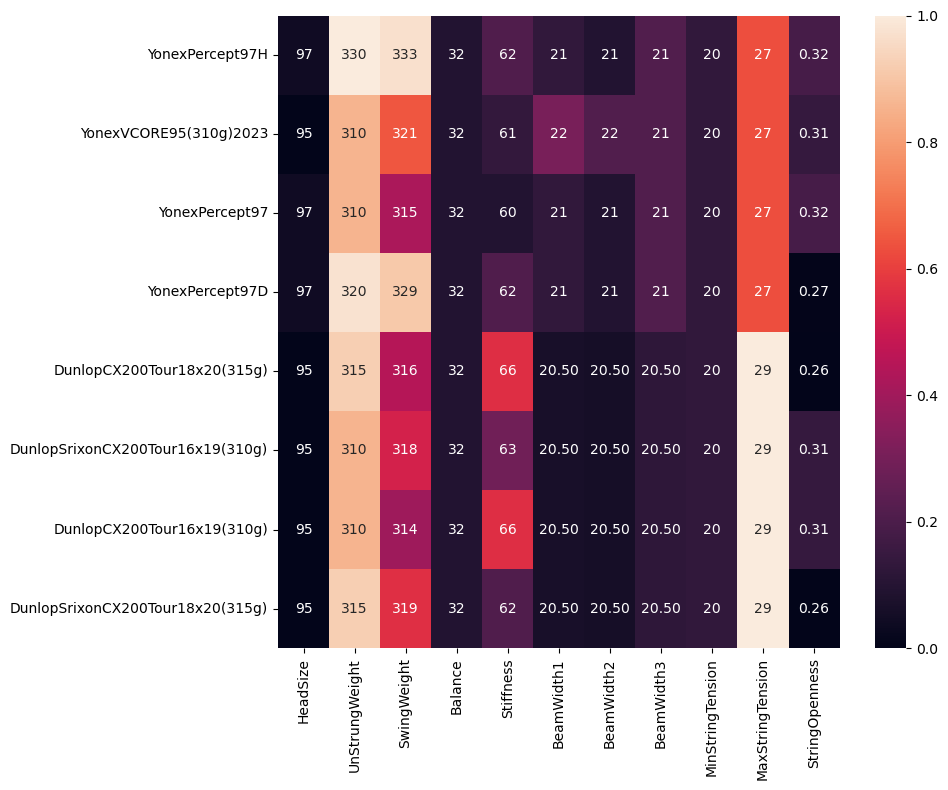

In [90]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
sns.heatmap(standardized_data[df2.Condition == 1],
            ax=ax,xticklabels=cols,
            yticklabels=df2.loc[df2.Condition == 1].index,
            annot=formated_data.values,
           fmt='')
plt.tight_layout()
plt.show()
fig.savefig('../plots/yonex_percept97H_heatmap.png')


In [ ]:
df2.loc[inds, cols]

In [ ]:
df2.to_csv('data/enchanced_data.csv', index=False)

In [ ]:
standardized_data = pd.DataFrame(standardized_data, columns=cols)

In [ ]:
standardized_data.to_csv('data/standardized_data.csv', index=False)